# SMS Spam Detection 

Goal of this notebook is to test different well-known classifiers with a plethora of features and see how they perform on the given dataset

### Import Libraries


In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
# For basic cleaning and data preprocessing 
import re
import string 
# wordcloud for data vizualization
from wordcloud import WordCloud

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pantelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Inspecting the dataset



Read the data using pandas' read_csv method 

In [2]:
DATAPATH = 'data/spam.csv'
df = pd.read_csv(DATAPATH, encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [3]:
# Shape of our data
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Have a look on the data


In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message" respectively

In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df.rename(columns = {'v1':'label','v2':'message'}, inplace=True)

Also drop any row which has any NaN value

In [6]:
df.dropna(inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Target count for data


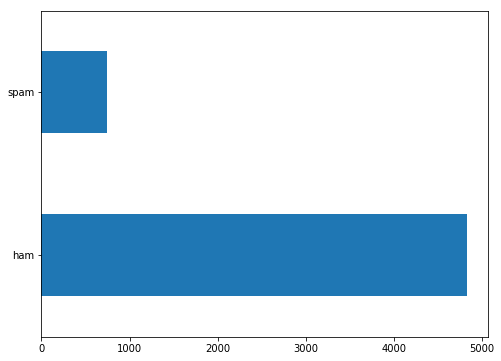

In [7]:
df['label'].value_counts().plot(kind='barh', figsize=(8, 6))

Vizualize data distribution using pie chart


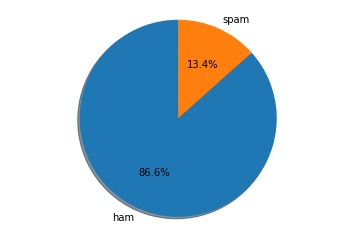

In [8]:
plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Have a look into the data grouped by into labels 'ham' or 'spam'


In [9]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's see how a ham and a spam sms look like

In [10]:
# Pick at random a ham sms 
df.loc[df['label'] == 'ham'].sample()

,label,message
1274,ham,Let me know how to contact you. I've you settl...


In [11]:
# Pick at random a spam sms 
df.loc[df['label'] == 'spam'].sample()

,label,message
334,spam,Valentines Day Special! Win over ÎµÂ£1000 in o...


### Text preprocessing

In [12]:
# Let's print the text before preprocessing step
print(df['message'])

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
5       FreeMsg Hey there darling it's been 3 week's n...
6       Even my brother is not like to speak with me. ...
7       As per your request 'Melle Melle (Oru Minnamin...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
10      I'm gonna be home soon and i don't want to tal...
11      SIX chances to win CASH! From 100 to 20,000 po...
12      URGENT! You have won a 1 week FREE membership ...
13      I've been searching for the right words to tha...
14                    I HAVE A DATE ON SUNDAY WITH WILL!!
15      XXXMobileMovieClub: To use your credit, click ...
16                             Oh k...i'm watching here:)
17      Eh u r

With the first glance it's easy to determine whether a sms is ham or spam

Now define our text precessing function.

In [25]:
def text_process(text):
    # Replace email addresses with 'emailaddr'
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr ', text)
    # Replace URLs with 'httpaddr'
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr ',
                     cleaned)
    # Replace money symbols with 'moneysymb'
    cleaned = re.sub(r'£|\$', 'moneysymb ', cleaned)
    # Replace phone numbers with 'phonenumbr'
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    # Collapse all whitespace
    cleaned = re.sub(r'[^\w\d\s]', ' ',text)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    # Convert all to lowercase
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    # Perform stemming and remove stop words
    stop_words = nltk.corpus.stopwords.words('english')
    stemmer = SnowballStemmer('english')
    stem_sentence = []
    token_words = word_tokenize(cleaned)
    stem_sentence = [stemmer.stem(word) for word in token_words 
                     if word not in set(stop_words)]
    return ' '.join(stem_sentence)


In [26]:
df['message'] = df['message'].apply(text_process)

Let's see our processed text now

In [27]:
print(df['message'])

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkts 2...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
5       freemsg hey darl 3 week word back like fun sti...
6           even brother like speak treat like aid patent
7       per request mell mell oru minnaminungint nurun...
8       winner valu network custom select receivea îµâ...
9       mobil 11 month u r entitl updat latest colour ...
10      gon na home soon want talk stuff anymor tonigh...
11      six chanc win cash 100 20 000 pound txt csh11 ...
12      urgent 1 week free membership îµâ 100 000 priz...
13      search right word thank breather promis wont t...
14                                            date sunday
15      xxxmobilemovieclub use credit click wap link n...
16                                             oh k watch
17      eh u r

### Exploratory Data Analysis (EDA)

Wordcloud is a useful visualization tool for you to have a rough estimate of the words that has the highest frequency in the data that you have

In [28]:
def generate_wordcloud(label):
    words = ''
    for msg in df.loc[df['label'] == label]['message']:
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

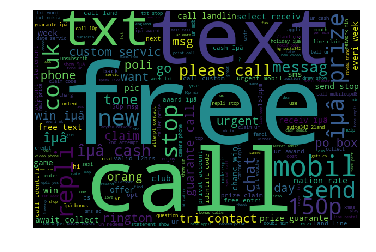

In [29]:
# generate wordcloud for 'spam' sms
generate_wordcloud('spam')

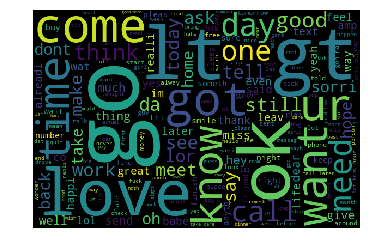

In [30]:
# generate wordcloud for 'ham' sms
generate_wordcloud('ham')

N-grams model visualization

In [31]:
def findNGrams(label, no):
    words = ''
    for msg in df.loc[df['label'] == label]['message']:
        words += msg + ' '
    tokenized = words.split()
    return ngrams(tokenized, no)
   

In [33]:
# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(findNGrams('ham',1))

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(10)

[(('u',), 1018),
 (('go',), 418),
 (('get',), 362),
 (('2',), 322),
 (('gt',), 318),
 (('lt',), 316),
 (('î',), 302),
 (('call',), 298),
 (('come',), 296),
 (('ok',), 287)]